# UltraGCN

Most Lightweight Ver.

$L_{graph} = \sum_{(u, i) \in E^{+}} w_{u i}^{+} e_u^{\top} e_i-\sum_{(u, j) \in E^{-}} w_{u j}^{-} e_u^{\top} e_j \quad$ with $\quad w_{u i}=\frac{1}{\sqrt{\operatorname{deg}(u) \operatorname{deg}(i)}}$

In [ ]:
# UltraGCN Implementation on MovieLens with Train/Test Split and Fixed Evaluation

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 1. Load and preprocess data
ratings = pd.read_csv('ratings.csv')
# Keep only positive feedback (implicit): rating >= 4
ratings = ratings[ratings['rating'] >= 4.0].reset_index(drop=True)

# 2. Leave-One-Out train/test split per user
train_list, test_list = [], []
# Ensure reproducibility
df = ratings.copy()
for user, grp in df.groupby('userId'):
    if len(grp) < 2:
        # Skip users with <2 interactions
        continue
    test_sample = grp.sample(n=1, random_state=42)
    train_sample = grp.drop(test_sample.index)
    train_list.append(train_sample)
    test_list.append(test_sample)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

# 3. Build ID mappings from union of train & test interactions
all_users = pd.concat([train_df['userId'], test_df['userId']]).unique()
all_items = pd.concat([train_df['movieId'], test_df['movieId']]).unique()
user2idx = {u: i for i, u in enumerate(all_users)}
item2idx = {i: j for j, i in enumerate(all_items)}

n_users = len(user2idx)
n_items = len(item2idx)

# Map raw IDs to indices
train_df['u'] = train_df['userId'].map(user2idx)
train_df['i'] = train_df['movieId'].map(item2idx)
test_df['u']  = test_df['userId'].map(user2idx)
test_df['i']  = test_df['movieId'].map(item2idx)

# 4. Build positive item sets and degree tensors from training data
train_pos = train_df.groupby('u')['i'].apply(set).to_dict()
train_user_deg = {u: len(train_pos.get(u, [])) for u in range(n_users)}
train_item_deg = train_df['i'].value_counts().to_dict()

# Convert degrees to tensors for fast lookup in GPU
user_deg_t = torch.tensor([train_user_deg.get(u,0) for u in range(n_users)], dtype=torch.float)
item_deg_t = torch.tensor([train_item_deg.get(i,0) for i in range(n_items)], dtype=torch.float)

# 5. BPR dataset sampling only from training positives
class BPRTrainDataset(Dataset):
    def __init__(self, user_pos, n_items):
        self.user_pos = user_pos
        self.users = list(user_pos.keys())
        self.n_items = n_items

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        u = self.users[idx]
        pos_item = np.random.choice(list(self.user_pos[u]))
        neg_item = np.random.randint(0, self.n_items)
        # resample until negative not in train positives
        while neg_item in self.user_pos[u]:
            neg_item = np.random.randint(0, self.n_items)
        return u, pos_item, neg_item

# 6. UltraGCN model definition
class UltraGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, lambda_graph=0.1):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.lambda_graph = lambda_graph
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, u, i, j):
        u_e = self.user_emb(u)
        i_e = self.item_emb(i)
        j_e = self.item_emb(j)
        pos_scores = (u_e * i_e).sum(dim=1)
        neg_scores = (u_e * j_e).sum(dim=1)
        return pos_scores, neg_scores

    def graph_loss(self, u, i, j, user_deg, item_deg):
        # edge-specific weights as 1/sqrt(deg_u * deg_i)
        # w_pos = 1.0 / torch.sqrt(user_deg[u] * item_deg[i] + 1e-8)
        w_pos = (1.0 / torch.sqrt(user_deg[u] * item_deg[i] + 1e-8)) * ((user_deg[u]+1)/(user_deg[u]+1e-8))
        # w_neg = 1.0 / torch.sqrt(user_deg[u] * item_deg[j] + 1e-8)
        w_neg = (1.0 / (user_deg[u]+1e-8)) * torch.sqrt((user_deg[u]+1) / (item_deg[j]+1))
        pos_s, neg_s = self.forward(u, i, j)
        return -(w_pos * pos_s - w_neg * neg_s).mean() ###

# 7. Evaluation: leave-one-out with negative sampling per user
import math

def evaluate(model, test_df, train_pos, n_items, k=10, device='cpu', num_neg=100):
    model.eval()
    HRs, NDCGs = [], []
    with torch.no_grad():
        # build test_pos map (one item per user)
        test_pos = test_df.set_index('u')['i'].to_dict()
        for u, pos_i in test_pos.items():
            # sample negatives
            negs = []
            while len(negs) < num_neg:
                j = np.random.randint(0, n_items)
                if j not in train_pos.get(u, set()) and j != pos_i:
                    negs.append(j)
            items = [pos_i] + negs
            # score
            u_tensor = torch.tensor([u]*len(items), dtype=torch.long).to(device)
            i_tensor = torch.tensor(items, dtype=torch.long).to(device)
            scores = (model.user_emb(u_tensor) * model.item_emb(i_tensor)).sum(dim=1)
            # rank items
            _, indices = torch.topk(scores, k)
            recs = [items[idx] for idx in indices.cpu().numpy()]
            # HR
            HRs.append(1 if pos_i in recs else 0)
            # NDCG
            if pos_i in recs:
                rank = recs.index(pos_i)
                NDCGs.append(1 / math.log2(rank + 2))
            else:
                NDCGs.append(0)
    return np.mean(HRs), np.mean(NDCGs)


In [ ]:
# 8. Training and evaluation loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = BPRTrainDataset(train_pos, n_items)
train_loader  = DataLoader(train_dataset, batch_size=1024, shuffle=True)

model = UltraGCN(n_users, n_items, emb_dim=64, lambda_graph=0.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Init lists for easy visualization
hr_list = []
ndcg_list = []

In [ ]:
for epoch in range(1, 101):
    model.train()
    total_loss = 0.0
    for u, i, j in train_loader:
        u, i, j = u.to(device), i.to(device), j.to(device)
        optimizer.zero_grad()
        pos_s, neg_s = model(u, i, j)
        bpr_loss = -torch.log(torch.sigmoid(pos_s - neg_s) + 1e-8).mean() ###
        g_loss   = model.graph_loss(u, i, j, user_deg_t.to(device), item_deg_t.to(device))
        loss     = bpr_loss + model.lambda_graph * g_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    hr, ndcg = evaluate(model, test_df, train_pos, n_items, k=10, device=device)
    hr_list.append(hr)
    ndcg_list.append(ndcg)
    print(f"Epoch {epoch} — Loss: {avg_loss:.4f} (BPR Loss: {bpr_loss.item():.4f}, g_loss: {g_loss.item():.4f}) | HR@10: {hr:.4f} | NDCG@10: {ndcg:.4f}")

Epoch 1 — Loss: 0.6932 (BPR Loss: 0.6932, g_loss: 0.0000) | HR@10: 0.0970 | NDCG@10: 0.0435
Epoch 2 — Loss: 0.6931 (BPR Loss: 0.6931, g_loss: -0.0000) | HR@10: 0.0987 | NDCG@10: 0.0418
Epoch 3 — Loss: 0.6931 (BPR Loss: 0.6931, g_loss: -0.0000) | HR@10: 0.1020 | NDCG@10: 0.0457
Epoch 4 — Loss: 0.6931 (BPR Loss: 0.6931, g_loss: -0.0000) | HR@10: 0.1069 | NDCG@10: 0.0471
Epoch 5 — Loss: 0.6931 (BPR Loss: 0.6931, g_loss: -0.0000) | HR@10: 0.0970 | NDCG@10: 0.0447
Epoch 6 — Loss: 0.6931 (BPR Loss: 0.6931, g_loss: -0.0000) | HR@10: 0.1168 | NDCG@10: 0.0523
Epoch 7 — Loss: 0.6930 (BPR Loss: 0.6930, g_loss: -0.0000) | HR@10: 0.1102 | NDCG@10: 0.0512
Epoch 8 — Loss: 0.6930 (BPR Loss: 0.6930, g_loss: -0.0000) | HR@10: 0.1102 | NDCG@10: 0.0493
Epoch 9 — Loss: 0.6930 (BPR Loss: 0.6930, g_loss: -0.0000) | HR@10: 0.1118 | NDCG@10: 0.0550
Epoch 10 — Loss: 0.6929 (BPR Loss: 0.6929, g_loss: -0.0000) | HR@10: 0.1135 | NDCG@10: 0.0552
Epoch 11 — Loss: 0.6929 (BPR Loss: 0.6929, g_loss: -0.0000) | HR@10: 0

# SVD

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

# 1. Load data
ratings = pd.read_csv("/content/ratings.csv")

# 2. Identify “positive” interactions (e.g. ratings ≥ 4)
pos_ratings = ratings[ratings.rating >= 4]

In [ ]:
# 3. Leave-one-out split on positives only:
#    for each user, randomly hold out one positive rating
test_pos = (
    pos_ratings
    .groupby("userId", group_keys=False)[["userId","movieId","rating"]]
    .apply(lambda grp: grp.sample(1, random_state=42))
)
#    train = all ratings minus those held‐out positives
train = ratings.drop(test_pos.index)

# 4. Re-index users/items in the TRAIN set
user_ids = train["userId"].unique()
item_ids = train["movieId"].unique()
u2idx = {u: i for i, u in enumerate(user_ids)}
i2idx = {i: j for j, i in enumerate(item_ids)}

n_users, n_items = len(user_ids), len(item_ids)

# 5. Build sparse user×item matrix from TRAIN
rows = train["userId"].map(u2idx)
cols = train["movieId"].map(i2idx)
data = train["rating"]
R = csr_matrix((data, (rows, cols)), shape=(n_users, n_items))

# 6. Demean by subtracting each user’s mean
user_means = np.array(R.sum(axis=1)).ravel() / (R.getnnz(axis=1) + 1e-8)
R_demeaned = R.copy().tolil()
for u in range(n_users):
    R_demeaned.data[u] = [val - user_means[u] for val in R_demeaned.data[u]]
R_demeaned = R_demeaned.tocsr()

# 7. Compute truncated SVD
k = 20
U, S, Vt = svds(R_demeaned, k=k)
S = np.diag(S)

# 8. Reconstruct the full score matrix
preds = U.dot(S).dot(Vt) + user_means.reshape(-1, 1)

# 9. Evaluation helpers
def hr_at_k(ranked, true_idx, k=10):
    return int(true_idx in ranked[:k])

def ndcg_at_k(ranked, true_idx, k=10):
    if true_idx in ranked[:k]:
        rank = ranked.index(true_idx)
        return 1.0 / np.log2(rank + 2)
    return 0.0

# 10. Evaluate on the held-out positives
hrs, ndcgs = [], []
for _, row in test_pos.iterrows():
    u_orig, i_orig = row["userId"], row["movieId"]
    if u_orig not in u2idx or i_orig not in i2idx:
        continue
    u, true_i = u2idx[u_orig], i2idx[i_orig]

    scores = preds[u].copy()
    # mask out anything the user saw in TRAIN
    seen = train[train.userId == u_orig]["movieId"].map(i2idx)
    scores[list(seen)] = -np.inf

    ranked = list(np.argsort(-scores))
    hrs.append(hr_at_k(ranked, true_i))
    ndcgs.append(ndcg_at_k(ranked, true_i))

svd_hr = np.mean(hrs)
svd_ndcg = np.mean(ndcgs)
print(f"HR@10  = {svd_hr:.4f}")
print(f"NDCG@10 = {svd_ndcg:.4f}")


HR@10  = 0.1304
NDCG@10 = 0.0847


In [ ]:
preds[1,:]

array([3.93886457, 3.93553381, 3.94977988, ..., 3.94323061, 3.94555624,
       3.94555624])

In [ ]:
import numpy as np

def hit_ratio_at_k(ranked_items, true_item, k=10):
    """
    HR@K = 1 if the true_item is among the top-K predictions, else 0.
    """
    top_k = ranked_items[:k]
    return 1 if true_item in top_k else 0

def ndcg_at_k(ranked_items, true_item, k=10):
    """
    NDCG@K for a single test case:
      If true_item is at position i (0-based) within top-K,
      DCG = 1 / log2(i + 2), and IDCG = 1 (best possible).
      Otherwise 0.
    """
    try:
        idx = ranked_items[:k].index(true_item)
        return 1.0 / np.log2(idx + 2)
    except ValueError:
        return 0.0

# Example usage over all test users:
def evaluate_all(test_set, preds, user_item_matrix, k=10):
    """
    test_set: list of (user_id, true_item) pairs
    model: your trained truncated-SVD model (with a .reconstruct(u_vec) or .predict methods)
    user_item_matrix: training matrix to filter out seen items
    """
    hr_list, ndcg_list = [], []
    for user_id, true_item in test_set:
        # 1) get the user's predicted scores for all items
        user_vec = user_item_matrix[user_id]
        scores = preds[user_id,:]                # shape [n_items]
        # 2) filter out items seen in training
        seen = set(np.where(user_vec > 0)[0])
        unseen_items = [(i, s) for i, s in enumerate(scores) if i not in seen]
        # 3) sort by score descending
        ranked = [i for i, _ in sorted(unseen_items, key=lambda x: x[1], reverse=True)]
        # 4) compute metrics
        hr_list.append(hit_ratio_at_k(ranked, true_item, k))
        ndcg_list.append(ndcg_at_k(ranked, true_item, k))

    avg_hr = np.mean(hr_list)
    avg_ndcg = np.mean(ndcg_list)
    return avg_hr, avg_ndcg

# If you already have your test_set and model ready:
# hr10, ndcg10 = evaluate_all(test_set, my_svd_model, train_matrix, k=10)
# print(f"HR@10: {hr10:.4f}, NDCG@10: {ndcg10:.4f}")


In [ ]:
test_pos

,userId,movieId,rating
116,1,1967,4.0
233,2,333,4.0
266,3,849,5.0
390,4,1282,5.0
546,5,475,5.0
...,...,...,...
98035,606,4881,4.5
98596,607,2334,4.0
98877,608,1261,4.0
99532,609,1150,4.0


In [ ]:
evaluate_all(test_pos, preds, R)

ValueError: too many values to unpack (expected 2)

# Comparison & Visualization

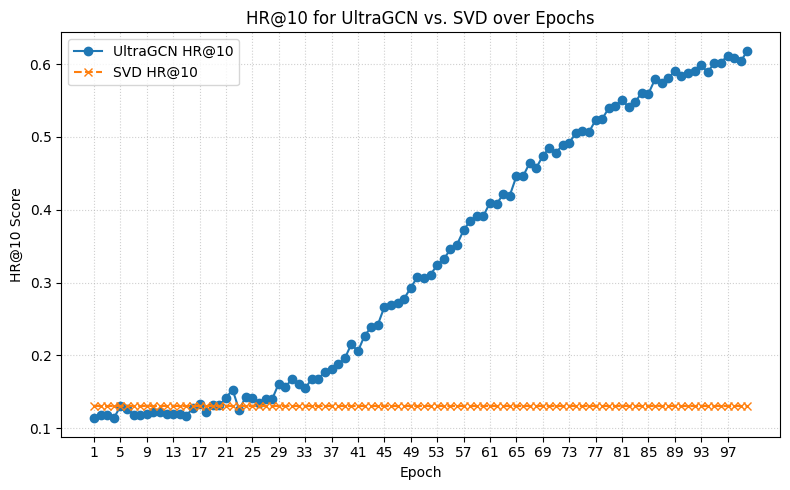

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 101)
svd_hr_list = [svd_hr] * len(epochs)

plt.figure(figsize=(8, 5))
plt.plot(epochs, hr_list, linestyle='-', marker='o', label='UltraGCN HR@10')
plt.plot(epochs, svd_hr_list, linestyle='--', marker='x', label='SVD HR@10')

plt.title('HR@10 for UltraGCN vs. SVD over Epochs')
plt.xlabel('Epoch')
plt.ylabel('HR@10 Score')
plt.xticks(epochs[::4])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

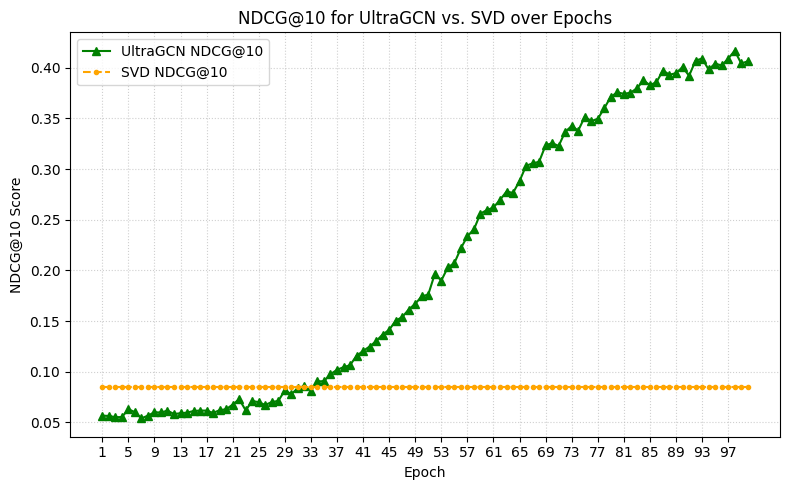

In [ ]:
svd_ndcg_list = [svd_ndcg] * len(epochs)

plt.figure(figsize=(8, 5))
plt.plot(epochs, ndcg_list, linestyle='-', marker='^', label='UltraGCN NDCG@10', color='green')
plt.plot(epochs, svd_ndcg_list, linestyle='--', marker='.', label='SVD NDCG@10', color='orange')

plt.title('NDCG@10 for UltraGCN vs. SVD over Epochs')
plt.xlabel('Epoch')
plt.ylabel('NDCG@10 Score')
plt.xticks(epochs[::4])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# UltraGCN

log-likelihood and sigmoid activation included:

$L_{\text {graph }}=-\sum_{(u, i) \in E^{+}} w_{u, i} \ln \sigma\left(e_u^{\top} e_i\right)-\sum_{(u, j) \in E^{-}} w_{u, j} \ln \sigma\left(-e_u^{\top} e_j\right),\quad$ with $\quad w_{u, i}=\frac{1}{\sqrt{\operatorname{deg}(u) \operatorname{deg}(i)}}$.

In [ ]:
# UltraGCN Implementation on MovieLens with Log-Likelihood Graph Constraint Loss

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

# 1. Load and preprocess data
ratings = pd.read_csv('ratings.csv')
# Binarize: rating >= 4 as positive implicit feedback
ratings = ratings[ratings['rating'] >= 4.0].reset_index(drop=True)

# 2. Leave-One-Out train/test split per user
train_list, test_list = [], []
for user, grp in ratings.groupby('userId'):
    if len(grp) < 2:
        continue
    test_sample = grp.sample(n=1, random_state=42)
    train_sample = grp.drop(test_sample.index)
    train_list.append(train_sample)
    test_list.append(test_sample)
train_df = pd.concat(train_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

# 3. Build ID mappings
all_users = pd.concat([train_df['userId'], test_df['userId']]).unique()
all_items = pd.concat([train_df['movieId'], test_df['movieId']]).unique()
user2idx = {u: i for i, u in enumerate(all_users)}
item2idx = {i: j for j, i in enumerate(all_items)}

n_users = len(user2idx)
n_items = len(item2idx)
train_df['u'] = train_df['userId'].map(user2idx)
train_df['i'] = train_df['movieId'].map(item2idx)
test_df['u']  = test_df['userId'].map(user2idx)
test_df['i']  = test_df['movieId'].map(item2idx)

# 4. Build training-positive sets and degree tensors
train_pos = train_df.groupby('u')['i'].apply(set).to_dict()
user_deg = {u: len(train_pos.get(u, [])) for u in range(n_users)}
item_deg = train_df['i'].value_counts().to_dict()
user_deg_t = torch.tensor([user_deg.get(u, 0) for u in range(n_users)], dtype=torch.float)
item_deg_t = torch.tensor([item_deg.get(i, 0) for i in range(n_items)], dtype=torch.float)

# 5. BPR training dataset
torch.manual_seed(0)
class BPRTrainDataset(Dataset):
    def __init__(self, user_pos, n_items):
        self.user_pos = user_pos
        self.users = list(user_pos.keys())
        self.n_items = n_items
    def __len__(self):
        return len(self.users)
    def __getitem__(self, idx):
        u = self.users[idx]
        i = np.random.choice(list(self.user_pos[u]))
        j = np.random.randint(0, self.n_items)
        while j in self.user_pos[u]:
            j = np.random.randint(0, self.n_items)
        return u, i, j

# 6. UltraGCN with log-likelihood graph constraint
class UltraGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, lambda_graph=0.1):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.lambda_graph = lambda_graph
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, u, i, j):
        u_e = self.user_emb(u)
        i_e = self.item_emb(i)
        j_e = self.item_emb(j)
        pos_scores = (u_e * i_e).sum(dim=1)
        neg_scores = (u_e * j_e).sum(dim=1)
        return pos_scores, neg_scores

    def graph_loss(self, u, i, j, user_deg, item_deg):
        # Compute edge-specific weights
        w_pos = 1.0 / torch.sqrt(user_deg[u] * item_deg[i] + 1e-8)
        w_neg = 1.0 / torch.sqrt(user_deg[u] * item_deg[j] + 1e-8)
        pos_s, neg_s = self.forward(u, i, j)
        # Log-likelihood terms
        pos_term = - w_pos * torch.log(torch.sigmoid(pos_s) + 1e-8)
        neg_term = - w_neg * torch.log(torch.sigmoid(-neg_s) + 1e-8)
        return (pos_term + neg_term).mean()

# 7. Evaluation: leave-one-out with negative sampling
def evaluate(model, test_df, train_pos, n_items, k=10, device='cpu', num_neg=100):
    model.eval()
    HRs, NDCGs = [], []
    test_map = test_df.set_index('u')['i'].to_dict()
    with torch.no_grad():
        for u, pos_i in test_map.items():
            negs = []
            while len(negs) < num_neg:
                j = np.random.randint(0, n_items)
                if j not in train_pos.get(u, {}) and j != pos_i:
                    negs.append(j)
            pool = [pos_i] + negs
            u_t = torch.tensor([u] * len(pool), dtype=torch.long).to(device)
            i_t = torch.tensor(pool, dtype=torch.long).to(device)
            scores = (model.user_emb(u_t) * model.item_emb(i_t)).sum(dim=1)
            _, idx = torch.topk(scores, k)
            recs = [pool[i] for i in idx.cpu().numpy()]
            HRs.append(1 if pos_i in recs else 0)
            if pos_i in recs:
                rank = recs.index(pos_i)
                NDCGs.append(1 / math.log2(rank + 2))
            else:
                NDCGs.append(0)
    return np.mean(HRs), np.mean(NDCGs)

# 8. Training loop
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = BPRTrainDataset(train_pos, n_items)
    train_loader  = DataLoader(train_dataset, batch_size=1024, shuffle=True)

    model = UltraGCN(n_users, n_items, emb_dim=64, lambda_graph=0.1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, 101):
        model.train()
        total_loss = 0.0
        for u, i, j in train_loader:
            u, i, j = u.to(device), i.to(device), j.to(device)
            optimizer.zero_grad()
            pos_s, neg_s = model(u, i, j)
            bpr_loss = -torch.log(torch.sigmoid(pos_s - neg_s) + 1e-8).mean()
            g_loss   = model.graph_loss(u, i, j, user_deg_t.to(device), item_deg_t.to(device))
            loss     = bpr_loss + model.lambda_graph * g_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        hr, ndcg = evaluate(model, test_df, train_pos, n_items, k=10, device=device)
        print(f"Epoch {epoch} — Loss: {avg_loss:.4f} (BPR Loss: {bpr_loss.item():.4f}, g_loss: {model.lambda_graph * g_loss.item():.4f})| HR@10: {hr:.4f} | NDCG@10: {ndcg:.4f}")


Epoch 1 — Loss: 1.8441 (BPR Loss: 0.6931, g_loss: 1.1509)| HR@10: 0.0855 | NDCG@10: 0.0384
Epoch 2 — Loss: 2.9829 (BPR Loss: 0.6932, g_loss: 2.2897)| HR@10: 0.0970 | NDCG@10: 0.0436
Epoch 3 — Loss: 6.4051 (BPR Loss: 0.6931, g_loss: 5.7120)| HR@10: 0.1069 | NDCG@10: 0.0465
Epoch 4 — Loss: 6.4030 (BPR Loss: 0.6931, g_loss: 5.7098)| HR@10: 0.0938 | NDCG@10: 0.0413
Epoch 5 — Loss: 1.8440 (BPR Loss: 0.6930, g_loss: 1.1509)| HR@10: 0.0954 | NDCG@10: 0.0422
Epoch 6 — Loss: 2.9847 (BPR Loss: 0.6930, g_loss: 2.2917)| HR@10: 0.1020 | NDCG@10: 0.0479
Epoch 7 — Loss: 0.7038 (BPR Loss: 0.6930, g_loss: 0.0107)| HR@10: 0.1086 | NDCG@10: 0.0484
Epoch 8 — Loss: 1.8443 (BPR Loss: 0.6930, g_loss: 1.1513)| HR@10: 0.1036 | NDCG@10: 0.0465
Epoch 9 — Loss: 4.1256 (BPR Loss: 0.6930, g_loss: 3.4326)| HR@10: 0.1053 | NDCG@10: 0.0507
Epoch 10 — Loss: 5.2644 (BPR Loss: 0.6930, g_loss: 4.5714)| HR@10: 0.0954 | NDCG@10: 0.0477
Epoch 11 — Loss: 1.8439 (BPR Loss: 0.6930, g_loss: 1.1509)| HR@10: 0.1118 | NDCG@10: 0.05

Try: BCE Loss instead of BPR

In [ ]:
# UltraGCN Implementation on MovieLens with Log-Likelihood Graph Constraint Loss

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

# 1. Load and preprocess data
ratings = pd.read_csv('ratings.csv')
# Binarize: rating >= 4 as positive implicit feedback
ratings = ratings[ratings['rating'] >= 4.0].reset_index(drop=True)

# 2. Leave-One-Out train/test split per user
train_list, test_list = [], []
for user, grp in ratings.groupby('userId'):
    if len(grp) < 2:
        continue
    test_sample = grp.sample(n=1, random_state=42)
    train_sample = grp.drop(test_sample.index)
    train_list.append(train_sample)
    test_list.append(test_sample)
train_df = pd.concat(train_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

# 3. Build ID mappings
all_users = pd.concat([train_df['userId'], test_df['userId']]).unique()
all_items = pd.concat([train_df['movieId'], test_df['movieId']]).unique()
user2idx = {u: i for i, u in enumerate(all_users)}
item2idx = {i: j for j, i in enumerate(all_items)}

n_users = len(user2idx)
n_items = len(item2idx)
train_df['u'] = train_df['userId'].map(user2idx)
train_df['i'] = train_df['movieId'].map(item2idx)
test_df['u']  = test_df['userId'].map(user2idx)
test_df['i']  = test_df['movieId'].map(item2idx)

# 4. Build training-positive sets and degree tensors
train_pos = train_df.groupby('u')['i'].apply(set).to_dict()
user_deg = {u: len(train_pos.get(u, [])) for u in range(n_users)}
item_deg = train_df['i'].value_counts().to_dict()
user_deg_t = torch.tensor([user_deg.get(u, 0) for u in range(n_users)], dtype=torch.float)
item_deg_t = torch.tensor([item_deg.get(i, 0) for i in range(n_items)], dtype=torch.float)

# 5. BPR training dataset
torch.manual_seed(0)
class BPRTrainDataset(Dataset):
    def __init__(self, user_pos, n_items):
        self.user_pos = user_pos
        self.users = list(user_pos.keys())
        self.n_items = n_items
    def __len__(self):
        return len(self.users)
    def __getitem__(self, idx):
        u = self.users[idx]
        i = np.random.choice(list(self.user_pos[u]))
        j = np.random.randint(0, self.n_items)
        while j in self.user_pos[u]:
            j = np.random.randint(0, self.n_items)
        return u, i, j

# 6. UltraGCN with log-likelihood graph constraint
class UltraGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, lambda_graph=0.1):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.lambda_graph = lambda_graph
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, u, i, j):
        u_e = self.user_emb(u)
        i_e = self.item_emb(i)
        j_e = self.item_emb(j)
        pos_scores = (u_e * i_e).sum(dim=1)
        neg_scores = (u_e * j_e).sum(dim=1)
        return pos_scores, neg_scores

    def graph_loss(self, u, i, j, user_deg, item_deg):
        w_pos = 1.0 / torch.sqrt(user_deg[u] * item_deg[i] + 1e-8)
        w_neg = 1.0 / torch.sqrt(user_deg[u] * item_deg[j] + 1e-8)
        pos_s, neg_s = self.forward(u, i, j)
        pos_term = -w_pos * torch.log(torch.sigmoid(pos_s) + 1e-8)
        neg_term = -w_neg * torch.log(torch.sigmoid(-neg_s) + 1e-8)
        return (pos_term + neg_term).sum()

# 7. Evaluation: leave-one-out with negative sampling
def evaluate(model, test_df, train_pos, n_items, k=10, device='cpu', num_neg=100):
    model.eval()
    HRs, NDCGs = [], []
    test_map = test_df.set_index('u')['i'].to_dict()
    with torch.no_grad():
        for u, pos_i in test_map.items():
            negs = []
            while len(negs) < num_neg:
                j = np.random.randint(0, n_items)
                if j not in train_pos.get(u, {}) and j != pos_i:
                    negs.append(j)
            pool = [pos_i] + negs
            u_t = torch.tensor([u] * len(pool), dtype=torch.long).to(device)
            i_t = torch.tensor(pool, dtype=torch.long).to(device)
            scores = (model.user_emb(u_t) * model.item_emb(i_t)).sum(dim=1)
            _, idx = torch.topk(scores, k)
            recs = [pool[i] for i in idx.cpu().numpy()]
            HRs.append(1 if pos_i in recs else 0)
            if pos_i in recs:
                rank = recs.index(pos_i)
                NDCGs.append(1 / math.log2(rank + 2))
            else:
                NDCGs.append(0)
    return np.mean(HRs), np.mean(NDCGs)

# 8. Training loop
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = BPRTrainDataset(train_pos, n_items)
    train_loader  = DataLoader(train_dataset, batch_size=1024, shuffle=True)

    model = UltraGCN(n_users, n_items, emb_dim=64, lambda_graph=0.0).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, 101):
        model.train()
        total_loss = 0.0
        for u, i, j in train_loader:
            u, i, j = u.to(device), i.to(device), j.to(device)
            optimizer.zero_grad()
            pos_s, neg_s = model(u, i, j)
            # Summed interaction loss per paper
            pos_loss = -torch.log(torch.sigmoid(pos_s) + 1e-8)
            neg_loss = -torch.log(torch.sigmoid(-neg_s) + 1e-8)
            interaction_loss = pos_loss.sum() + neg_loss.sum()
            # Graph constraint loss
            g_loss   = model.graph_loss(u, i, j, user_deg_t.to(device), item_deg_t.to(device))
            loss     = interaction_loss + model.lambda_graph * g_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        hr, ndcg = evaluate(model, test_df, train_pos, n_items, k=10, device=device)
        print(f"Epoch {epoch} — Loss: {avg_loss:.4f} (BPR Loss: {bpr_loss.item():.4f}, g_loss: {model.lambda_graph * g_loss.item():.4f})| HR@10: {hr:.4f} | NDCG@10: {ndcg:.4f}")


Epoch 1 — Loss: 842.8702 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.0938 | NDCG@10: 0.0411
Epoch 2 — Loss: 842.8622 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.0954 | NDCG@10: 0.0446
Epoch 3 — Loss: 842.8313 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.0872 | NDCG@10: 0.0395
Epoch 4 — Loss: 842.8511 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.0921 | NDCG@10: 0.0401
Epoch 5 — Loss: 842.8289 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.1069 | NDCG@10: 0.0478
Epoch 6 — Loss: 842.8090 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.1003 | NDCG@10: 0.0466
Epoch 7 — Loss: 842.7980 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.1102 | NDCG@10: 0.0476
Epoch 8 — Loss: 842.7736 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.0987 | NDCG@10: 0.0439
Epoch 9 — Loss: 842.7898 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.1003 | NDCG@10: 0.0454
Epoch 10 — Loss: 842.7443 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 0.0954 | NDCG@10: 0.0425
Epoch 11 — Loss: 842.7439 (BPR Loss: 0.6734, g_loss: 0.0000)| HR@10: 